In [ ]:
# Mount Google Drive, load API keys for Quandl, and set up environment variables for API access
from google.colab import drive
import json

drive.mount('/content/drive')

from pathlib import Path
HDF_PATH = Path('drive', 'MyDrive', 'ML4T', 'data.h5')

Mounted at /content/drive


# Prediction of Stock Returns with Linear Regression

In this section, we will predict stock returns using linear regression models.


## Imports & Settings

We import the necessary libraries and set up the environment for the analysis.


In [ ]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from time import time
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
sns.set_style('darkgrid')
idx = pd.IndexSlice
YEAR = 252


## Load Data

In this section, we load the data from the HDF5 file and prepare it for analysis.


In [ ]:
# Load data from the HDF5 file
with pd.HDFStore(HDF_PATH) as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

# Rename the index levels for better readability
data.index.names = ['symbol', 'date']

# Drop columns containing 'lag' in their names
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)

# Display information about the data including null counts
data.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1889936 entries, (Timestamp('2013-07-03 00:00:00'), 'A') to (Timestamp('2017-11-29 00:00:00'), 'ZUMZ')
Data columns (total 45 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   volume                  1889936 non-null  float64
 1   dollar_vol              1889936 non-null  float64
 2   dollar_vol_1m           1889936 non-null  float64
 3   dollar_vol_rank         1889936 non-null  float64
 4   rsi                     1889936 non-null  float64
 5   bb_high                 1889936 non-null  float64
 6   bb_low                  1889936 non-null  float64
 7   atr                     1889936 non-null  float64
 8   macd                    1889936 non-null  float64
 9   return_1d               1889936 non-null  float64
 10  return_5d               1889936 non-null  float64
 11  return_10d              1889936 non-null  float64
 12  return_21d              1889936 non-nul

## Select Investment Universe

We will filter the data to include only the top 100 most liquid stocks based on the dollar volume rank.


In [ ]:
# Filter the data for the top 100 most liquid stocks
data = data[data.dollar_vol_rank < 100]

# Display information about the filtered data including null counts
data.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109748 entries, (Timestamp('2013-07-03 00:00:00'), 'AAL') to (Timestamp('2014-12-10 00:00:00'), 'ZTS')
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   volume                  109748 non-null  float64
 1   dollar_vol              109748 non-null  float64
 2   dollar_vol_1m           109748 non-null  float64
 3   dollar_vol_rank         109748 non-null  float64
 4   rsi                     109748 non-null  float64
 5   bb_high                 109748 non-null  float64
 6   bb_low                  109748 non-null  float64
 7   atr                     109748 non-null  float64
 8   macd                    109748 non-null  float64
 9   return_1d               109748 non-null  float64
 10  return_5d               109748 non-null  float64
 11  return_10d              109748 non-null  float64
 12  return_21d              109748 non-null  float64
 13 

## Create Model Data

In this section, we prepare the model data by separating the target variables and the features.


In [ ]:
# Separate the target variables
y = data.filter(like='target')

# Drop the target variables and other unnecessary columns from the features
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume'], axis=1)


## Custom MultipleTimeSeriesCV

We will implement a custom cross-validation class for multiple time series.



In [ ]:
class MultipleTimeSeriesCV:
    """
    Custom cross-validation class for multiple time series data.

    This class generates tuples of train_idx, test_idx pairs.
    Assumes the MultiIndex contains levels 'symbol' and 'date'.
    Purges overlapping outcomes to avoid data leakage.
    """

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        """
        Initialize the MultipleTimeSeriesCV class.

        Parameters:
        n_splits (int): Number of splits for cross-validation.
        train_period_length (int): Number of days in the training period.
        test_period_length (int): Number of days in the test period.
        lookahead (int): Number of days to look ahead. Used to ensure no overlap between training and testing data.
        shuffle (bool): Whether to shuffle the training data indices. Default is False.
        """
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        """
        Generate indices to split data into training and test sets.

        Parameters:
        X (DataFrame): Feature data.
        y (DataFrame): Target data (default is None).
        groups (None): Not used, present for API consistency by convention.

        Yields:
        train_idx (array-like): The training set indices for that split.
        test_idx (array-like): The testing set indices for that split.
        """
        # Get unique dates from the data index
        unique_dates = X.index.get_level_values('date').unique()
        # Sort dates in descending order
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            # Determine the indices for the test and training periods
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        # Reset the index to get a DataFrame of dates
        dates = X.reset_index()[['date']]
        for train_start, train_end, test_start, test_end in split_idx:
            # Get training indices based on the calculated date ranges
            train_idx = dates[(dates.date > days[train_start])
                              & (dates.date <= days[train_end])].index
            # Get testing indices based on the calculated date ranges
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            # Shuffle the training indices if shuffle is set to True
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            # Yield the training and testing indices
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        """
        Get the number of splits.

        Parameters:
        X (DataFrame): Feature data.
        y (DataFrame): Target data.
        groups (None): Not used, present for API consistency by convention.

        Returns:
        int: Number of splits.
        """
        return self.n_splits


## Verify that the Custom Cross-Validation Works

We will verify that the custom cross-validation class `MultipleTimeSeriesCV` works as expected by printing the train and test period information for the first few splits.


In [ ]:
# Define the parameters for the custom cross-validation
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR / test_period_length)
lookahead = 1

# Initialize the custom cross-validation class
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

# Ensure the MultiIndex names are correct
data.index.names = ['date', 'symbol']

# Verify that the custom cross-validation works as expected
i = 0
for train_idx, test_idx in cv.split(X=data):
    # Get the training and testing data
    train = data.iloc[train_idx]
    train_dates = pd.to_datetime(train.index.get_level_values('date'), errors='coerce')
    test = data.iloc[test_idx]
    test_dates = pd.to_datetime(test.index.get_level_values('date'), errors='coerce')

    # Verify no overlap between train and test sets
    df = pd.concat([train.reset_index(), test.reset_index()])
    n = len(df)
    assert n == len(df.drop_duplicates()), "Data leakage detected!"

    # Print the sizes and date ranges for training and testing sets
    print(train.groupby(level='symbol').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='symbol').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())

    i += 1
    if i == 10:
        break


63 2017-08-16 2017-11-14 10 2017-11-15 2017-11-29
63 2017-08-02 2017-10-30 10 2017-10-31 2017-11-14
63 2017-07-19 2017-10-16 10 2017-10-17 2017-10-30
63 2017-07-05 2017-10-02 10 2017-10-03 2017-10-16
63 2017-06-20 2017-09-18 10 2017-09-19 2017-10-02
63 2017-06-06 2017-09-01 10 2017-09-05 2017-09-18
63 2017-05-22 2017-08-18 10 2017-08-21 2017-09-01
63 2017-05-08 2017-08-04 10 2017-08-07 2017-08-18
63 2017-04-24 2017-07-21 10 2017-07-24 2017-08-04
62 2017-04-10 2017-07-07 10 2017-07-10 2017-07-21


## Visualization Helper Functions

We define helper functions for visualizing the results of our predictions, including scatter plots, IC distributions, and rolling IC plots.


### Prediction vs Actual Scatter Plot

This function creates a scatter plot comparing predicted values to actual values.


In [ ]:
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')


### Daily IC Distribution

This function plots the distribution of the Information Coefficient (IC).


In [ ]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.histplot(df.ic, kde=True, ax=ax)
    else:
        ax = sns.histplot(df.ic, kde=True)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()


### Rolling Daily IC

This function plots the rolling mean of the Information Coefficient (IC) and Root Mean Squared Error (RMSE).


In [ ]:
def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()


## Linear Regression with sklearn

We set up and run cross-validation using linear regression.


### Set up cross-validation

We define the parameters and initialize the custom cross-validation class.


In [ ]:
# Define the parameters for the custom cross-validation
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR / test_period_length)
lookahead = 1

# Initialize the custom cross-validation class
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)


### Run cross-validation with LinearRegression

We run cross-validation using linear regression and collect the predictions and scores.


In [ ]:
# Run cross-validation with LinearRegression
%%time
target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()

for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)

    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    preds_by_day = preds.groupby(level='date')
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted, x.actuals)[0] * 100).to_frame('ic'),
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted, y_true=x.actuals))).to_frame('rmse')], axis=1)

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)


CPU times: user 13.9 s, sys: 3.01 s, total: 16.9 s
Wall time: 13.6 s


## Persist Results

We will save the results of the linear regression model to an HDF5 file for future use and reload them to verify.


In [ ]:
# Save the linear regression scores and predictions to an HDF5 file
lr_scores.to_hdf(HDF_PATH, 'lr/scores')
lr_predictions.to_hdf(HDF_PATH, 'lr/predictions')

# Reload the saved scores and predictions to verify
lr_scores = pd.read_hdf(HDF_PATH, 'lr/scores')
lr_predictions = pd.read_hdf(HDF_PATH, 'lr/predictions')


## Evaluate Results

We will evaluate the performance of the linear regression model by calculating the overall Information Coefficient (IC) and visualizing the predictions against the actual values.


### Calculate Information Coefficient

We calculate the overall Information Coefficient (IC) between the predicted and actual values.


In [ ]:
# Calculate the overall Information Coefficient (IC)
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')
# Output: Information Coefficient (overall): 1.531% (p-value: 0.0031%)


Information Coefficient (overall): 1.384% (p-value: 0.0165%)


### Prediction vs Actuals Scatter

We create a scatter plot comparing the predicted values to the actual values.


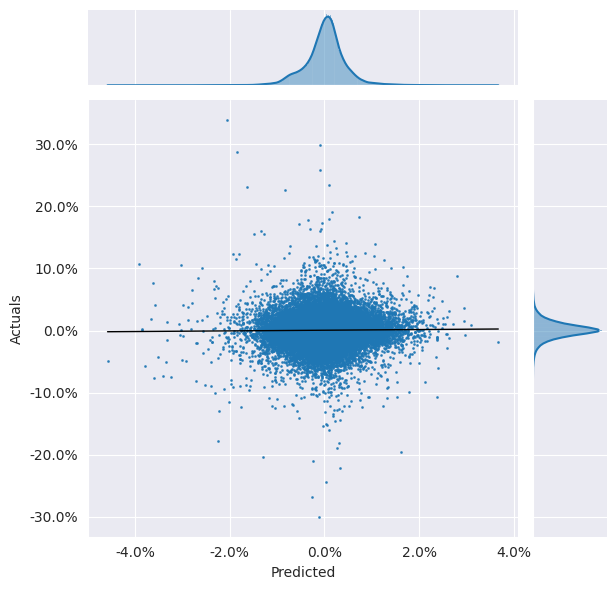

In [ ]:
# Plot the predictions vs. actual values
plot_preds_scatter(lr_predictions)


### Daily IC Distribution

We plot the distribution of the daily Information Coefficient (IC) to assess the consistency of the model's performance.


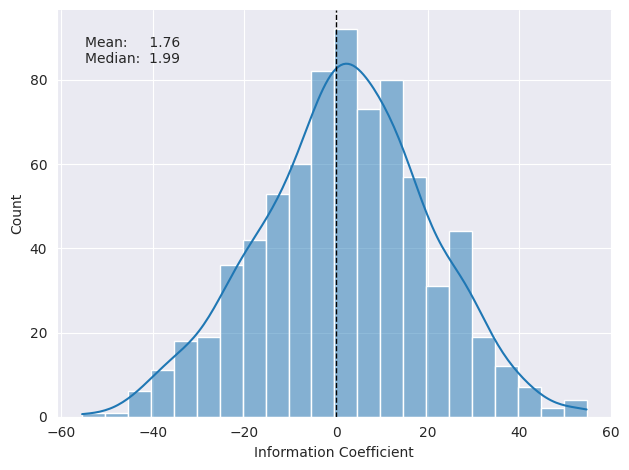

In [ ]:
# Plot the distribution of the daily Information Coefficient (IC)
plot_ic_distribution(lr_scores)


### Rolling Daily IC

We plot the rolling mean of the daily Information Coefficient (IC) and Root Mean Squared Error (RMSE) to observe the model's performance over time.


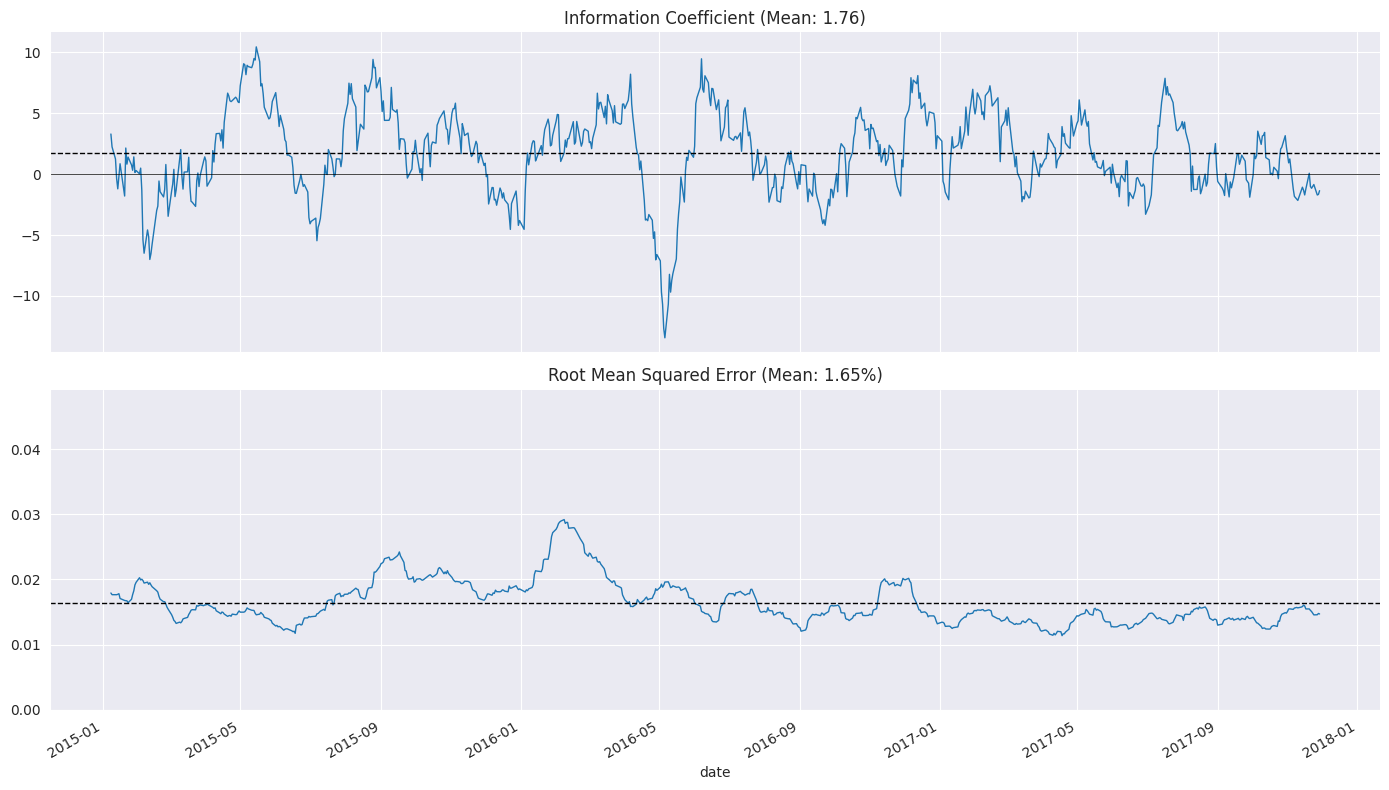

In [ ]:
# Plot the rolling mean of the daily Information Coefficient (IC) and RMSE
plot_rolling_ic(lr_scores)


## Ridge Regression

We will perform Ridge Regression with different alpha values, using cross-validation to evaluate the model's performance.


### Define Cross-Validation Parameters

We define the parameters for cross-validation and the range of alpha values for Ridge Regression.


In [ ]:
# Define the alpha values for Ridge Regression
ridge_alphas = np.logspace(-4, 4, 9)
ridge_alphas = sorted(list(ridge_alphas) + list(ridge_alphas * 5))

# Define the parameters for the custom cross-validation
n_splits = int(3 * YEAR / test_period_length)
train_period_length = 63
test_period_length = 10
lookahead = 1

# Initialize the custom cross-validation class
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)


### Run Cross-Validation

We run cross-validation using Ridge Regression and collect the coefficients, scores, and predictions for each alpha value.


In [ ]:
# Prepare the feature set by dropping year-related columns
X = X.drop([c for c in X.columns if 'year' in c], axis=1)

In [ ]:
# Run cross-validation with Ridge Regression
%%time
target = f'target_{lookahead}d'
ridge_coeffs, ridge_scores, ridge_predictions = {}, [], []

for alpha in ridge_alphas:
    print(alpha, end=' ', flush=True)
    start = time()
    model = Ridge(alpha=alpha,
                  fit_intercept=False,
                  random_state=42)

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])

    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        X_train, y_train = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted, x.actuals)[0] * 100).to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted, y_true=x.actuals))).to_frame('rmse')], axis=1)

        ridge_scores.append(scores.assign(alpha=alpha))
        ridge_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)
    ridge_coeffs[alpha] = np.mean(coeffs, axis=0)

print('\n')


0.0001 0.0005 0.001 0.005 0.01 0.05 0.1 0.5 1.0 5.0 10.0 50.0 100.0 500.0 1000.0 5000.0 10000.0 50000.0 

CPU times: user 1min 54s, sys: 1min 20s, total: 3min 15s
Wall time: 2min 3s


## Persist Results

We will save the results of the Ridge Regression model to an HDF5 file for future use and reload them to verify.


In [ ]:
# Combine and save the Ridge Regression scores to an HDF5 file
ridge_scores = pd.concat(ridge_scores)
ridge_scores.to_hdf(HDF_PATH, 'ridge/scores')

# Save the Ridge Regression coefficients to an HDF5 file
ridge_coeffs = pd.DataFrame(ridge_coeffs, index=X.columns).T
ridge_coeffs.to_hdf(HDF_PATH, 'ridge/coeffs')

# Combine and save the Ridge Regression predictions to an HDF5 file
ridge_predictions = pd.concat(ridge_predictions)
ridge_predictions.to_hdf(HDF_PATH, 'ridge/predictions')

# Reload the saved scores, coefficients, and predictions to verify
ridge_scores = pd.read_hdf(HDF_PATH, 'ridge/scores')
ridge_coeffs = pd.read_hdf(HDF_PATH, 'ridge/coeffs')
ridge_predictions = pd.read_hdf(HDF_PATH, 'ridge/predictions')


## Evaluate Ridge Results

We will evaluate the performance of the Ridge Regression model by calculating the overall Information Coefficient (IC) and examining the IC distribution for different alpha values.


### Calculate Information Coefficient

We calculate the overall Information Coefficient (IC) between the predicted and actual values for the Ridge Regression model.


In [ ]:
# Calculate the overall Information Coefficient (IC) for the Ridge Regression model
ridge_r, ridge_p = spearmanr(ridge_predictions.actuals, ridge_predictions.predicted)
print(f'Information Coefficient (overall): {ridge_r:.3%} (p-value: {ridge_p:.4%})')
# Output: Information Coefficient (overall): 1.551% (p-value: 0.0000%)


Information Coefficient (overall): 1.473% (p-value: 0.0000%)


### IC Distribution by Alpha

We examine the distribution of the Information Coefficient (IC) for different alpha values used in the Ridge Regression model.


In [ ]:
# Group the Ridge Regression scores by alpha and describe the IC distribution
ridge_ic_distribution = ridge_scores.groupby('alpha').ic.describe()
ridge_ic_distribution


,count,mean,std,min,25%,50%,75%,max
alpha,,,,,,,,
0.0001,750.0,1.756024,18.387913,-55.423624,-10.099258,1.993816,13.562847,54.650588
0.0005,750.0,1.756024,18.387913,-55.423624,-10.099258,1.993816,13.562847,54.650588
0.0010,750.0,1.755997,18.387919,-55.423624,-10.099258,1.993816,13.562847,54.650588
0.0050,750.0,1.756016,18.388077,-55.423624,-10.099258,1.993816,13.562847,54.650588
0.0100,750.0,1.756042,18.387910,-55.423624,-10.099258,1.993816,13.562847,54.650588
0.0500,750.0,1.755647,18.388594,-55.423624,-10.099258,1.993816,13.562847,54.650588
0.1000,750.0,1.755172,18.388070,-55.423624,-10.099258,1.993816,13.562847,54.650588
0.5000,750.0,1.762143,18.390456,-55.418677,-10.064626,2.030303,13.649752,54.650588
1.0000,750.0,1.762985,18.390734,-55.372913,-10.036577,2.020408,13.645114,54.707483


## Evaluate Ridge Regression Results

We will visualize the cross-validation performance of the Ridge Regression model, highlighting the best alpha values based on mean and median Information Coefficient (IC).


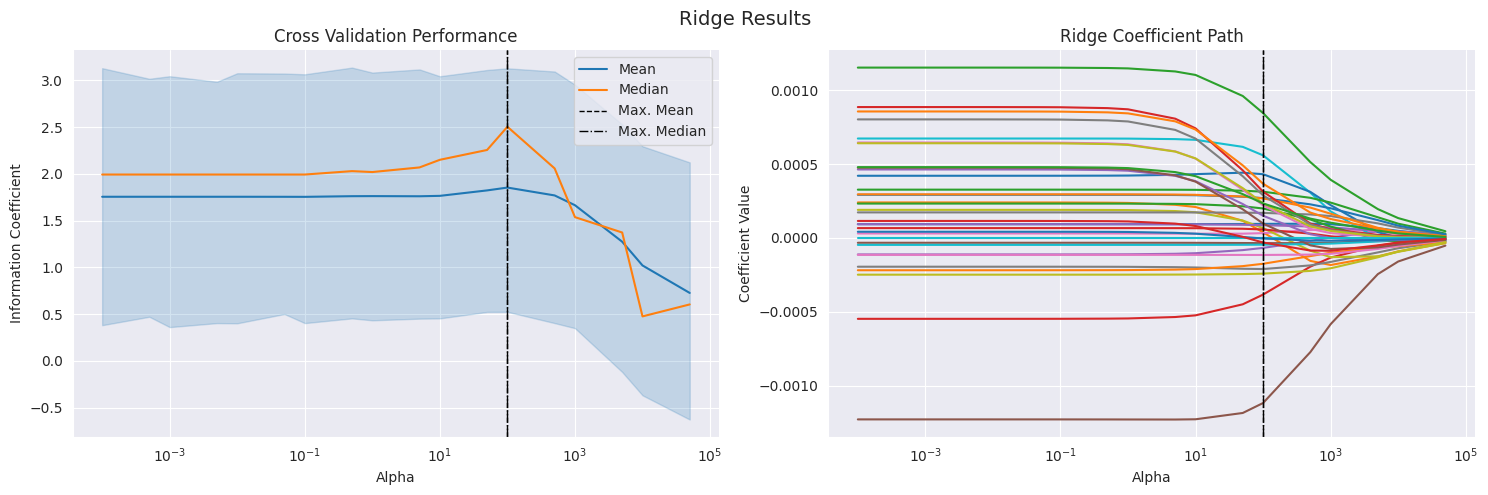

In [ ]:
# Set up the figure and axes for plotting
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

# Calculate mean and median IC for each alpha
scores_by_alpha = ridge_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

# Plot the mean IC for each alpha
ax = sns.lineplot(x='alpha',
                  y='ic',
                  data=ridge_scores,
                  estimator=np.mean,
                  label='Mean',
                  ax=axes[0])

# Plot the median IC for each alpha
scores_by_alpha['median'].plot(logx=True,
                               ax=axes[0],
                               label='Median')

# Highlight the best alpha values
axes[0].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[0].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

# Plot the Ridge coefficient path
ridge_coeffs.plot(logx=True,
                  legend=False,
                  ax=axes[1],
                  title='Ridge Coefficient Path')

# Highlight the best alpha values
axes[1].axvline(best_alpha_mean,
                ls='--',
                c='k',
                lw=1,
                label='Max. Mean')
axes[1].axvline(best_alpha_median,
                ls='-.',
                c='k',
                lw=1,
                label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

# Set the overall title and adjust the layout
fig.suptitle('Ridge Results', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)


## Evaluate Best Ridge Regression Model

We will evaluate the best Ridge Regression model by examining the daily Information Coefficient (IC) distribution and identifying the top 10 coefficients.


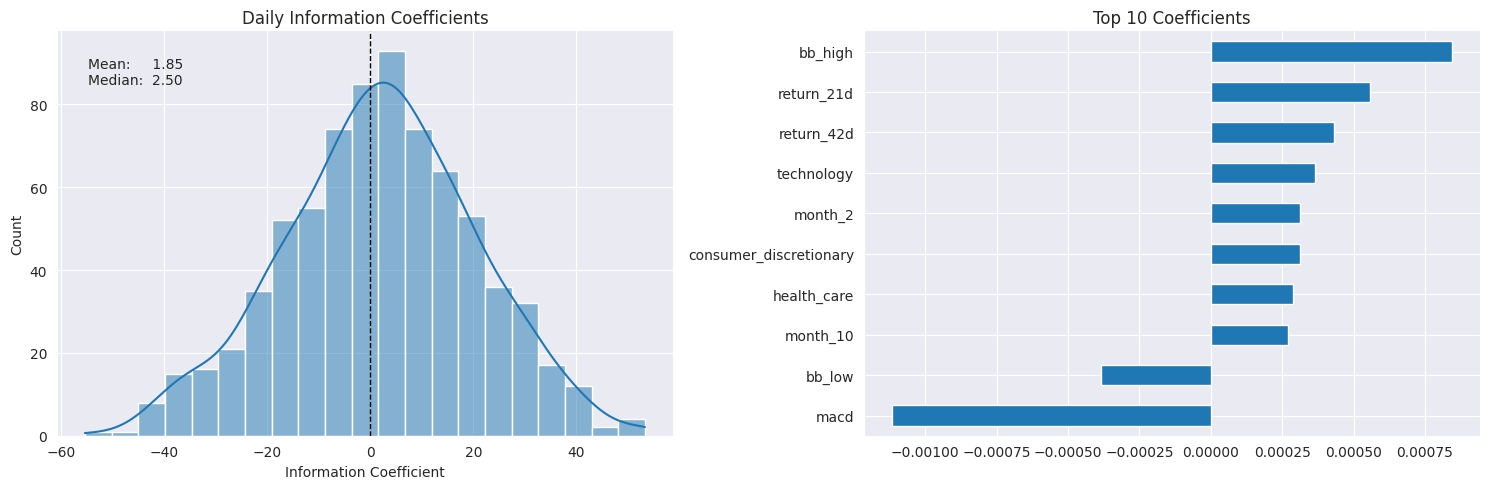

In [ ]:
# Identify the best alpha based on mean IC
best_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()

# Set up the figure and axes for plotting
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

# Plot the IC distribution for the best alpha
plot_ic_distribution(ridge_scores[ridge_scores.alpha == best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

# Identify the top 10 coefficients for the best alpha
top_coeffs = ridge_coeffs.loc[best_alpha].abs().sort_values().tail(10).index
top_coeffs.tolist()

# Plot the top 10 coefficients for the best alpha
ridge_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1],
                                                                 title='Top 10 Coefficients')

# Finalize the plot
sns.despine()
fig.tight_layout()


### Plot Rolling IC for Best Ridge Regression Model

We will plot the rolling Information Coefficient (IC) for the best Ridge Regression model to observe its performance over time.


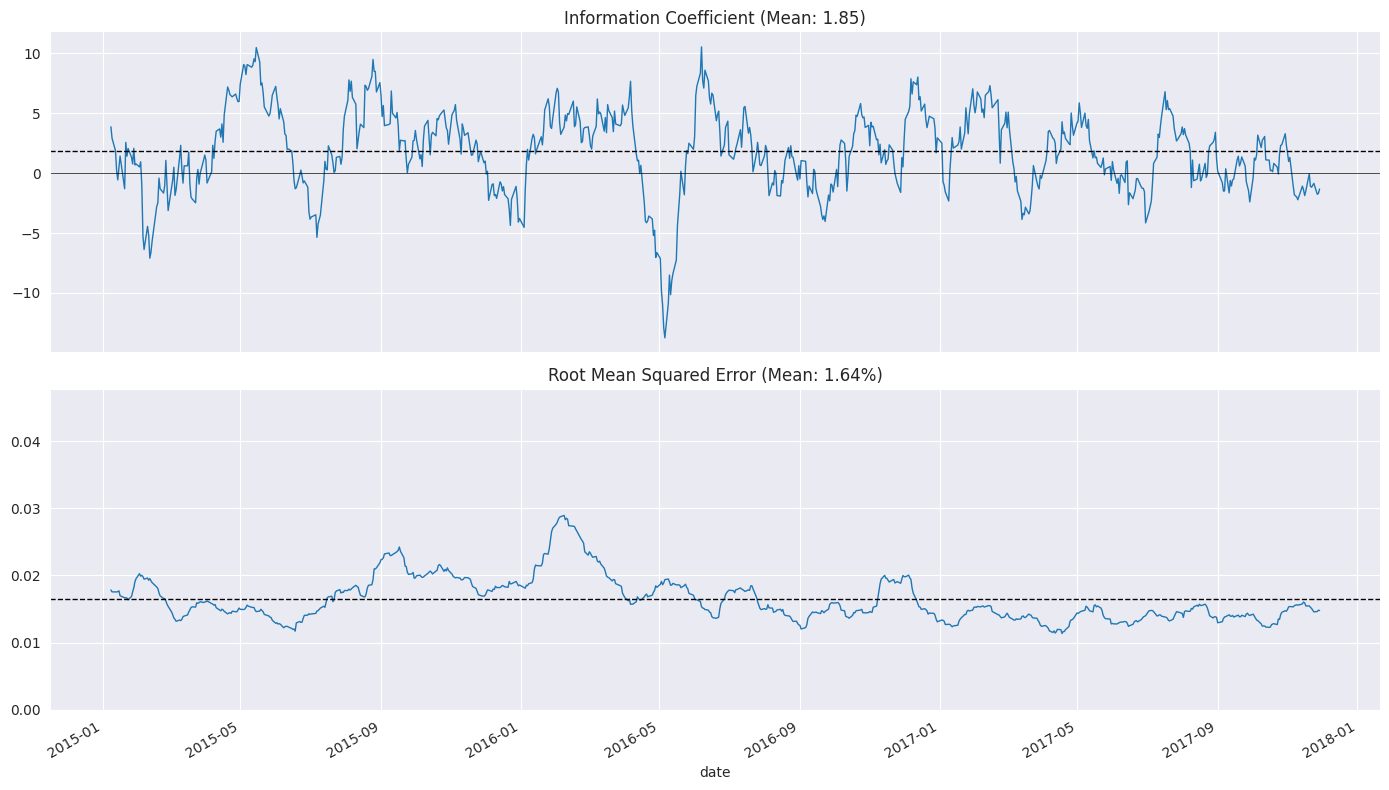

In [ ]:
# Plot the rolling IC for the best alpha
plot_rolling_ic(ridge_scores[ridge_scores.alpha == best_alpha])


## Lasso Cross-Validation

We will perform cross-validation with Lasso regression to evaluate the model's performance across different alpha values.


### Define Cross-Validation Parameters

We define the parameters for cross-validation and the range of alpha values for Lasso regression.


In [ ]:
# Define the alpha values for Lasso regression
lasso_alphas = np.logspace(-10, -3, 8)

# Define the parameters for the custom cross-validation
train_period_length = 63
test_period_length = 10
YEAR = 252
n_splits = int(3 * YEAR / test_period_length)  # three years
lookahead = 1

# Initialize the custom cross-validation class
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)


### Run Cross-Validation with Lasso Regression

We run cross-validation using Lasso regression and collect the coefficients, scores, and predictions for each alpha value.


In [ ]:
# Prepare the feature set by dropping year-related columns
scaler = StandardScaler()
X = X.drop([c for c in X.columns if 'year' in c], axis=1)


In [ ]:

# Run cross-validation with Lasso regression
%%time

lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    model = Lasso(alpha=alpha,
                  fit_intercept=False,  # StandardScaler centers data
                  random_state=42,
                  tol=1e-3,
                  max_iter=1000,
                  warm_start=True,
                  selection='random')

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)])
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        t = time()
        X_train, y_train = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]

        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)

        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted, x.actuals)[0] * 100).to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted, y_true=x.actuals))).to_frame('rmse')],
                           axis=1)

        lasso_scores.append(scores.assign(alpha=alpha))
        lasso_predictions.append(preds.assign(alpha=alpha))

        coeffs.append(pipe.named_steps['model'].coef_)

    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)


1e-10 1e-09 1e-08 1e-07 1e-06 1e-05 0.0001 0.001 CPU times: user 2min 10s, sys: 49.1 s, total: 2min 59s
Wall time: 2min 15s


## Persist Results

We will save the results of the Lasso regression model to an HDF5 file for future use and reload them to verify.


In [ ]:
# Combine and save the Lasso regression scores to an HDF5 file
lasso_scores = pd.concat(lasso_scores)
lasso_scores.to_hdf(HDF_PATH, 'lasso/scores')

# Save the Lasso regression coefficients to an HDF5 file
lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_coeffs.to_hdf(HDF_PATH, 'lasso/coeffs')

# Combine and save the Lasso regression predictions to an HDF5 file
lasso_predictions = pd.concat(lasso_predictions)
lasso_predictions.to_hdf(HDF_PATH, 'lasso/predictions')


## Evaluate Lasso Results

We will evaluate the performance of the Lasso regression model by calculating the overall Information Coefficient (IC) and examining the IC distribution for different alpha values.


In [ ]:
# Identify the best alpha based on mean IC
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

# Filter predictions for the best alpha
preds = lasso_predictions[lasso_predictions.alpha == best_alpha]

# Calculate the overall Information Coefficient (IC) for the Lasso regression model
lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')
# Output: Information Coefficient (overall): 3.595% (p-value: 0.0000%)

# Group the Lasso regression scores by alpha and describe the IC distribution
lasso_ic_distribution = lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])
lasso_ic_distribution


Information Coefficient (overall): 3.512% (p-value: 0.0000%)


,mean,median
alpha,,
1.000000e-10,1.760384,1.993816
1.000000e-09,1.760173,1.993816
1.000000e-08,1.759704,1.993816
1.000000e-07,1.762306,1.994434
1.000000e-06,1.764843,1.856314
1.000000e-05,1.830427,2.403543
1.000000e-04,1.414460,2.009895
1.000000e-03,1.021349,1.126163


## Lasso Coefficient Path

We will visualize the cross-validation performance of the Lasso regression model, highlighting the best alpha values based on mean and median Information Coefficient (IC).


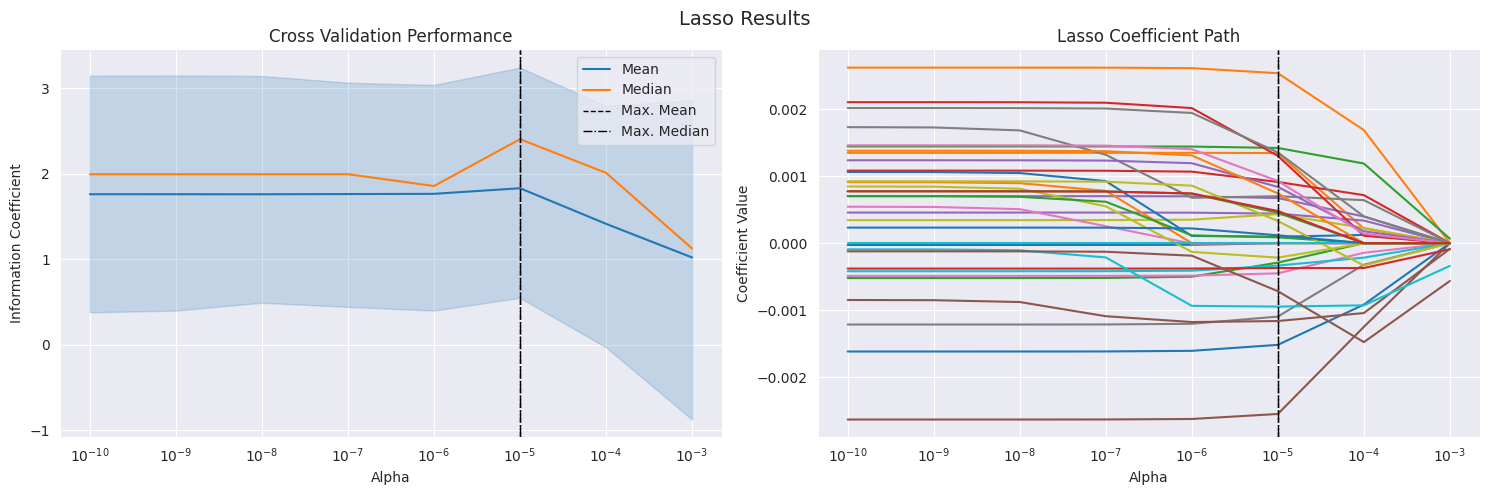

In [ ]:
# Remove duplicate alpha labels
lasso_scores = lasso_scores.reset_index().drop_duplicates(subset=['alpha', 'date']).set_index(['alpha', 'date'])

# Set up the figure and axes for plotting
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 5))

# Calculate mean and median IC for each alpha
scores_by_alpha = lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])
best_alpha_mean = scores_by_alpha['mean'].idxmax()
best_alpha_median = scores_by_alpha['median'].idxmax()

# Plot the mean IC for each alpha
ax = sns.lineplot(x='alpha', y='ic', data=lasso_scores.reset_index(), estimator=np.mean, label='Mean', ax=axes[0])

# Plot the median IC for each alpha on the same axis, with logarithmic scaling for the x-axis
scores_by_alpha['median'].plot(logx=True, ax=axes[0], label='Median')

# Highlight the best alpha values
axes[0].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[0].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Information Coefficient')
axes[0].set_title('Cross Validation Performance')

# Plot the Lasso coefficient path for each alpha
lasso_coeffs.plot(logx=True, legend=False, ax=axes[1], title='Lasso Coefficient Path')

# Highlight the best alpha values
axes[1].axvline(best_alpha_mean, ls='--', c='k', lw=1, label='Max. Mean')
axes[1].axvline(best_alpha_median, ls='-.', c='k', lw=1, label='Max. Median')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coefficient Value')

# Set the overall title and adjust the layout
fig.suptitle('Lasso Results', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.9)
sns.despine()


## Lasso IC Distribution and Top 10 Features

We will evaluate the best Lasso regression model by examining the daily Information Coefficient (IC) distribution and identifying the top 10 coefficients.


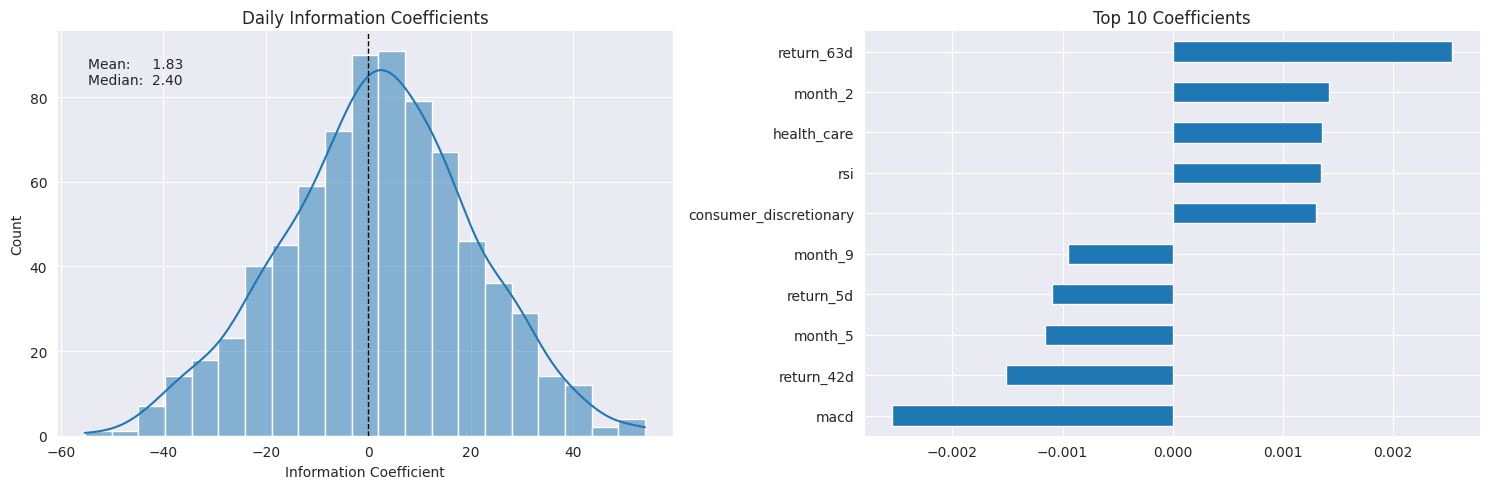

In [ ]:
# Ensure alpha is accessible
lasso_scores = lasso_scores.reset_index()

# Identify the best alpha based on mean IC
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()

# Set up the figure and axes for plotting
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

# Plot the IC distribution for the best alpha
plot_ic_distribution(lasso_scores[lasso_scores.alpha == best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

# Identify the top 10 coefficients for the best alpha
top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values().tail(10).index
top_coeffs.tolist()

# Plot the top 10 coefficients for the best alpha in a horizontal bar chart
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

# Finalize the plot
sns.despine()
fig.tight_layout()


## Compare Results

We will compare the performance of the Linear Regression, Ridge Regression, and Lasso Regression models by examining their daily Information Coefficient (IC) and Root Mean Squared Error (RMSE).


In [ ]:
# Identify the best alphas for Ridge and Lasso regressions
best_ridge_alpha = ridge_scores.groupby('alpha').ic.mean().idxmax()
best_ridge_preds = ridge_predictions[ridge_predictions.alpha == best_ridge_alpha]
best_ridge_scores = ridge_scores[ridge_scores.alpha == best_ridge_alpha]

best_lasso_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
best_lasso_preds = lasso_predictions[lasso_predictions.alpha == best_lasso_alpha]
best_lasso_scores = lasso_scores[lasso_scores.alpha == best_lasso_alpha]

# Combine the scores from all models for comparison
df = pd.concat([lr_scores.assign(Model='Linear Regression'),
                best_ridge_scores.assign(Model='Ridge Regression'),
                best_lasso_scores.assign(Model='Lasso Regression')]).reset_index()


In [ ]:
# Adjust column names and drop unnecessary columns
df = df.drop(columns=['index', 'alpha', 'date'], errors='ignore')
df.columns = ['IC', 'RMSE', 'Model']


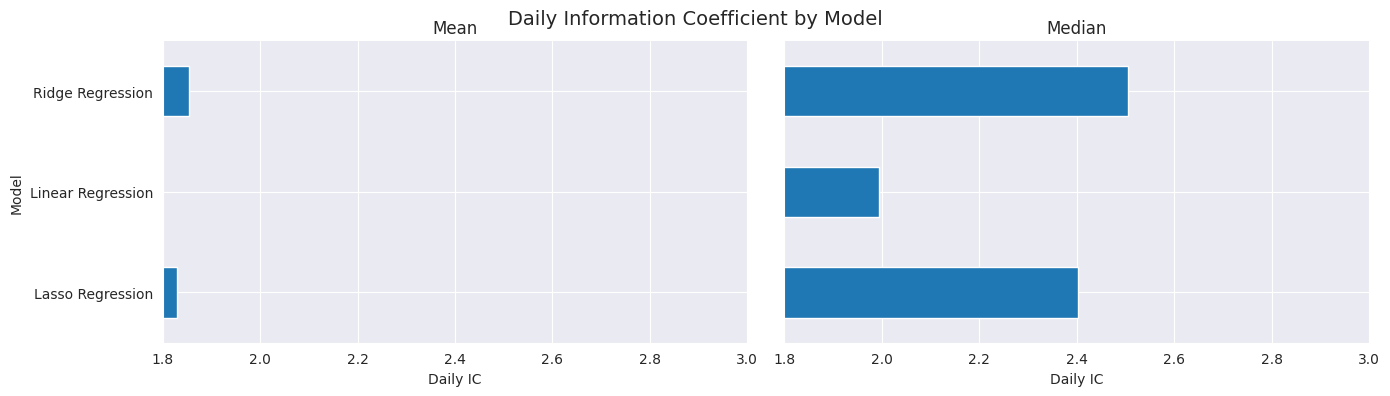

In [ ]:
# Calculate mean and median IC for each model
scores = df.groupby('Model').IC.agg(['mean', 'median'])

# Set up the figure and axes for plotting
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True, sharex=True)

# Plot mean IC for each model
scores['mean'].plot.barh(ax=axes[0], xlim=(0, 2), title='Mean')

# Plot median IC for each model
scores['median'].plot.barh(ax=axes[1], xlim=(1.8, 3), title='Median')

# Set axis labels
axes[0].set_xlabel('Daily IC')
axes[1].set_xlabel('Daily IC')

# Set the overall title and adjust the layout
fig.suptitle('Daily Information Coefficient by Model', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9)
